In [6]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import h5py
import tensorflow as tf

In [7]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
keras.backend.image_data_format()

'channels_first'

In [9]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [10]:
x_train = x_train / 255.
x_test = x_test / 255.

In [11]:
x_train.shape

(60000, 28, 28)

In [12]:
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

In [13]:
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.models import Sequential

In [14]:
import keras.backend.tensorflow_backend as tfback

In [15]:
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus

In [16]:
lenet = Sequential()
lenet.add(Conv2D(6, kernel_size=3, strides=1, padding='same', input_shape=(1, 28, 28), activation="relu", \
                name='conv1', data_format="channels_first"))

lenet.add(MaxPool2D(pool_size=2, strides=2, name='pool1', data_format='channels_first'))

lenet.add(Conv2D(16, kernel_size=5, strides=1, padding='valid', activation="relu", \
                 name='conv2', data_format="channels_first"))

lenet.add(MaxPool2D(pool_size=2, strides=2, name='pool2', data_format="channels_first"))
lenet.add(Flatten(name='flatten', data_format="channels_last"))
lenet.add(Dense(120, activation="relu", name='fc1'))
lenet.add(Dense(84, activation="relu", name='fc2'))
lenet.add(Dense(10, activation='softmax', name='softmax'))

In [17]:
lenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 6, 28, 28)         60        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 6, 14, 14)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 10, 10)        2416      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 5, 5)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 120)               48120     
_________________________________________________________________
fc2 (Dense)                  (None, 84)               

In [18]:
lenet.load_weights("LeNet_NCHW2.h5")

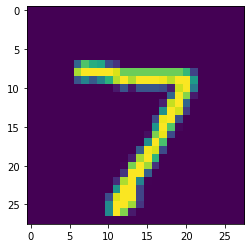

In [19]:
plt.imshow(x_test[0][0])

In [20]:
# with open("MNIST_in_7.dat","w") as f:
#     for i in x_test[0]:
#         for j in i:
#             f.write(str(j[0])+"\n")

In [21]:
image_7 = np.expand_dims(x_test[0], axis=0)
predictions = lenet.predict(image_7)

In [22]:
predictions

array([[4.1750793e-13, 1.0217871e-07, 4.7025295e-09, 7.9027460e-09,
        4.6409793e-11, 4.0204432e-14, 3.6066829e-20, 9.9999988e-01,
        5.8345616e-12, 4.1460571e-10]], dtype=float32)

In [23]:
from keras.models import Model

In [24]:
m_fc_in = Model(inputs=lenet.input, outputs=lenet.get_layer('flatten').output)
Y_fc_in = m_fc_in.predict(image_7)
print(Y_fc_in.shape)

(1, 400)


In [25]:
with open("fc_ifm_in.dat","w") as f:
    for i in Y_fc_in[0]:
        f.write(str(i)+"\n")

In [26]:
m_fc_out = Model(inputs=lenet.input, outputs=lenet.get_layer('fc1').output)
Y_fc_out = m_fc_out.predict(image_7)
print(Y_fc_out.shape)

(1, 120)


In [27]:
with open("fc_ofm_out.dat","w") as f:
    for i in Y_fc_out[0]:
        f.write(str(i)+"\n")

In [28]:
#Get Weights
f = h5py.File("LeNet_NCHW2.h5","r")

In [29]:
list(f.keys())

['model_weights', 'optimizer_weights']

In [30]:
fc1_bias = f['model_weights']['fc1']['fc1']['bias:0'][:]

In [31]:
with open("fc_bias_in.dat","w") as f:
    for i in fc1_bias:
        f.write(str(i)+"\n")

In [32]:
#Get Weights
f = h5py.File("LeNet_NCHW2.h5","r")

In [33]:
fc1_kernel = f['model_weights']['fc1']['fc1']['kernel:0']

In [34]:
fc1_kernel = np.moveaxis(fc1_kernel, 1, 0)
fc1_kernel.shape

(120, 400)

In [130]:
with open("fc_kernel_in.dat","w") as f:
    for i in fc1_kernel:
        for j in i:
            f.write(str(j)+"\n")

In [132]:
fc1_kernel.shape

(120, 400)

In [133]:
fc1_bias.shape

(120,)

In [144]:
fc_out=np.zeros(120)
for i in range(len(fc1_bias)):
    fc_out[i] = fc1_bias[i]
    for j in range(fc1_kernel.shape[1]):
        fc_out[i] += fc1_kernel[i][j]*Y_fc_in[0][j]

In [146]:
with open("fc_out.dat","w") as f:
    for i in fc_out:
        f.write(str(i)+"\n")